## Movie project multiple linear regresion 

In [1]:
# Data wrangling
# ==============================================================================
import pandas as pd
import numpy as np

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocessing and modeling
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuring matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuring warnings
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [3]:
movies = pd.read_csv('DataBase_Clean_2-Copy1.csv', index_col='title')
movies.head()

,personal_rating,imdb,year,genre,duration,budget,box_office,fan_rating
title,,,,,,,,
Deadpool,90,8.0,2016,action,108,58.0,782.600000,77.705882
Deadpool 2,95,7.6,2018,action,110,110.0,785.800000,78.352941
Jojo Rabbit,80,7.9,2019,comedy,108,14.0,90.335025,74.625000
Onward,80,7.4,2021,kids,102,175.0,141.495051,76.222222
Dolittle,80,5.6,2020,adventure,101,180.0,251.500000,87.941176


In [4]:
movies.describe()

,personal_rating,imdb,year,duration,budget,box_office,fan_rating
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,90.547297,7.242568,2011.040541,115.040541,102.098931,472.550497,84.027926
std,7.742747,0.934311,9.685446,24.375151,81.237286,412.783019,7.465067
min,60.000000,4.300000,1975.000000,72.000000,0.050000,0.408400,53.666667
25%,86.500000,6.600000,2006.000000,96.000000,28.750000,140.325000,79.654412
50%,90.000000,7.300000,2012.500000,109.000000,90.000000,352.016034,84.854396
75%,96.000000,8.000000,2019.000000,127.250000,154.000000,714.737760,89.413462
max,100.000000,9.000000,2023.000000,194.000000,393.216000,2264.743305,96.428571


En esta sección del código estamos analizando la relación que tiene cada una de las variables en nuestra base de datos para determinar cuál es la que podríamos predecir. En este caso, decidimos predecir la variable de 'fan_rating', utilizando las variables independientes de 'imdb','budget','personal_rating' y 'duration'.

In [5]:
#correlaciones 
# Correlation between numerical columns
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    This functions converts a pandas correlation matrix to tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = movies.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
33,budget,box_office,0.504556,0.504556
39,box_office,budget,0.504556,0.504556
6,personal_rating,fan_rating,0.417070,0.417070
42,fan_rating,personal_rating,0.417070,0.417070
22,duration,imdb,0.347259,0.347259
10,imdb,duration,0.347259,0.347259
30,budget,year,0.249966,0.249966
18,year,budget,0.249966,0.249966
27,duration,fan_rating,0.245208,0.245208
45,fan_rating,duration,0.245208,0.245208


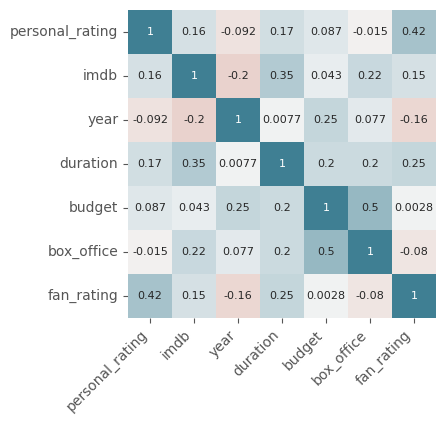

In [6]:
# Heatmap for correlation matrix
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

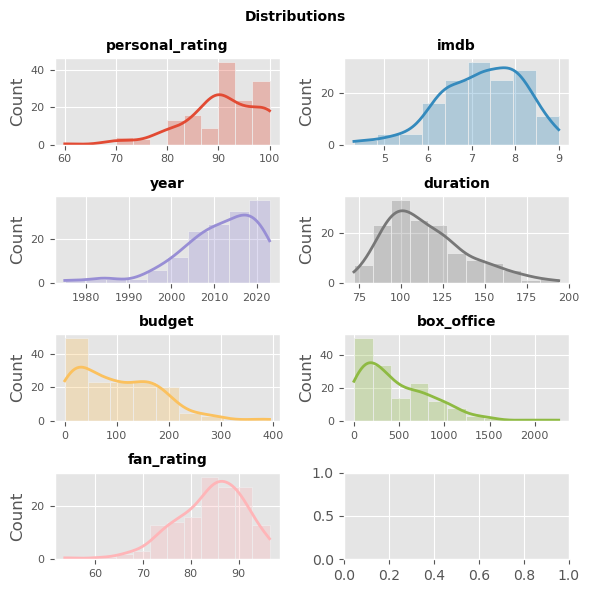

In [7]:
# Distribution plots for each numerical variable
# ==============================================================================
# 
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6, 6))
axes = axes.flat
columnas_numeric = movies.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = movies,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distributions', fontsize = 10, fontweight = "bold");

In [8]:
movies.columns

Index(['personal_rating', 'imdb', 'year', 'genre', 'duration', 'budget',
       'box_office', 'fan_rating'],
      dtype='object')

In [9]:
movies.describe()

,personal_rating,imdb,year,duration,budget,box_office,fan_rating
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,90.547297,7.242568,2011.040541,115.040541,102.098931,472.550497,84.027926
std,7.742747,0.934311,9.685446,24.375151,81.237286,412.783019,7.465067
min,60.000000,4.300000,1975.000000,72.000000,0.050000,0.408400,53.666667
25%,86.500000,6.600000,2006.000000,96.000000,28.750000,140.325000,79.654412
50%,90.000000,7.300000,2012.500000,109.000000,90.000000,352.016034,84.854396
75%,96.000000,8.000000,2019.000000,127.250000,154.000000,714.737760,89.413462
max,100.000000,9.000000,2023.000000,194.000000,393.216000,2264.743305,96.428571


En esta sección, estamos haciendo el análisis de variables dependientes e independientes con el fin 
de obtener el anáñisis de datos que nos ayudaría a determinar la exactitud de nuestro modelo mediante la R^2 y el intercepto.





In [10]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating','imdb']]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ duration + budget + personal_rating + imdb', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.707
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.58e-05
Time:                        11:58:03   Log-Likelihood:                -387.68
No. Observations:                 118   AIC:                             785.4
Df Residuals:                     113   BIC:                             799.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          41.0293      8.498      4.828      0.000      24.192      57.866
duration            0.0529      0.027      1.950      0.054      -0.001       0.107
budget             -0.0071      0.008     -0.902      0.369      -0.023       0.009
personal_rating     0.4094      0.086      4.778      0.000       0.240       0.579
imdb                0.0782      0.710      0.110      0.912      -1.328       1.485
==============================================================================
Omnibus:                       13.619   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.635
Skew:                          -0.823   Prob(JB):                     0.000664
Kurtosis:                       3.519   Cond. No.                     2.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Al hacer el análisis, nos dimos cuenta que nuestra R^2 era demasiado baja para poder realizar una buena regresión lineal múltiple, por lo que decidimos eliminar las variables en las que P>|t| fuera mayor a 0.05; esto con el fin de elevar nuestro valor de R^2 y aportar más exactitud al modelo. 
Al final solamente dejamos las variables de imdb y budget, ya que fueron las que tenían el valor de P>|t| más grande.

In [11]:
# Model fitting using matrices
# ==============================================================================
# Add a column of 1s to the predictor matrix
X_train = sm.add_constant(X_train, prepend=True)

In [12]:
model = sm.OLS(endog=y_train, exog=X_train,)
model = model.fit()
#print(model.summary())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.707
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.58e-05
Time:                        11:58:05   Log-Likelihood:                -387.68
No. Observations:                 118   AIC:                             785.4
Df Residuals:                     113   BIC:                             799.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              41.0293      8.498      4.828      0.000      24.192      57.866
duration            0.0529      0.027      1.950      0.054      -0.001       0.107
budget             -0.0071      0.008     -0.902      0.369      -0.023       0.009
personal_rating     0.4094      0.086      4.778      0.000       0.240       0.579
imdb                0.0782      0.710      0.110      0.912      -1.328       1.485
==============================================================================
Omnibus:                       13.619   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.635
Skew:                          -0.823   Prob(JB):                     0.000664
Kurtosis:                       3.519   Cond. No.                     2.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Eliminamos la variable de fan_rating primero. Sin embargo, nos dimos cuenta que nuestra R^2 seguía siendo muy baja, por lo que continuamos eliminando más variables.

In [13]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating']]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ duration + budget + personal_rating', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     10.36
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           4.39e-06
Time:                        11:58:07   Log-Likelihood:                -387.68
No. Observations:                 118   AIC:                             783.4
Df Residuals:                     114   BIC:                             794.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          41.3649      7.899      5.237      0.000      25.717      57.013
duration            0.0539      0.025      2.127      0.036       0.004       0.104
budget             -0.0072      0.008     -0.921      0.359      -0.023       0.008
personal_rating     0.4108      0.084      4.866      0.000       0.244       0.578
==============================================================================
Omnibus:                       13.861   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.951
Skew:                          -0.829   Prob(JB):                     0.000567
Kurtosis:                       3.543   Cond. No.                     2.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration','personal_rating',]]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ duration + personal_rating', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     15.14
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.46e-06
Time:                        11:58:07   Log-Likelihood:                -388.12
No. Observations:                 118   AIC:                             782.2
Df Residuals:                     115   BIC:                             790.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          41.1607      7.891      5.216      0.000      25.531      56.791
duration            0.0482      0.025      1.962      0.052      -0.000       0.097
personal_rating     0.4125      0.084      4.890      0.000       0.245       0.580
==============================================================================
Omnibus:                       13.820   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.892
Skew:                          -0.826   Prob(JB):                     0.000584
Kurtosis:                       3.547   Cond. No.                     1.93e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Train-test Splitting
# ==============================================================================
X = movies[['personal_rating',]]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ personal_rating', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     25.79
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.47e-06
Time:                        11:58:08   Log-Likelihood:                -390.06
No. Observations:                 118   AIC:                             784.1
Df Residuals:                     116   BIC:                             789.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          45.0429      7.732      5.826      0.000      29.729      60.357
personal_rating     0.4309      0.085      5.079      0.000       0.263       0.599
==============================================================================
Omnibus:                       17.708   Durbin-Watson:                   2.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.445
Skew:                          -0.944   Prob(JB):                     3.63e-05
Kurtosis:                       3.771   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Con esto, concluímos que nuestra base de datos no es apta para regresión múltiple con la variable de 'fan_rating'

In [16]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating','imdb','fan_rating','year']]
y = movies['box_office']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='box_office ~ duration + budget + personal_rating + imdb + fan_rating + year', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             box_office   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     10.89
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.64e-09
Time:                        11:58:09   Log-Likelihood:                -851.41
No. Observations:                 118   AIC:                             1717.
Df Residuals:                     111   BIC:                             1736.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -827.5412   6948.922     -0.119      0.905   -1.46e+04    1.29e+04
duration            0.8053      1.419      0.568      0.571      -2.006       3.617
budget              2.7888      0.421      6.624      0.000       1.955       3.623
personal_rating    -2.6163      4.827     -0.542      0.589     -12.182       6.949
imdb              113.0163     37.317      3.029      0.003      39.069     186.963
fan_rating         -1.6788      4.843     -0.347      0.730     -11.275       7.918
year                0.2429      3.409      0.071      0.943      -6.512       6.998
==============================================================================
Omnibus:                       42.125   Durbin-Watson:                   1.752
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.922
Skew:                           1.328   Prob(JB):                     1.11e-25
Kurtosis:                       7.040   Cond. No.                     4.50e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Decidimos probar el análisis para predecir la varible de 'box_office', ya que este proceso con la variable que habíamos elegido al principio no dio un buen resultado

Repetimos el proceso anterior con la variable de 'box_office'

In [17]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating','imdb','fan_rating']]
y = movies['box_office']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='box_office ~ duration + budget + personal_rating + imdb + fan_rating', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             box_office   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     13.19
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           4.23e-10
Time:                        11:58:11   Log-Likelihood:                -851.42
No. Observations:                 118   AIC:                             1715.
Df Residuals:                     112   BIC:                             1731.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -333.5082    477.279     -0.699      0.486   -1279.174     612.158
duration            0.8119      1.410      0.576      0.566      -1.981       3.605
budget              2.7962      0.406      6.882      0.000       1.991       3.601
personal_rating    -2.6257      4.804     -0.547      0.586     -12.144       6.893
imdb              112.4519     36.305      3.097      0.002      40.518     184.386
fan_rating         -1.7022      4.810     -0.354      0.724     -11.233       7.829
==============================================================================
Omnibus:                       41.967   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.253
Skew:                           1.324   Prob(JB):                     1.55e-25
Kurtosis:                       7.029   Cond. No.                     3.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### De nuevo, fuimos poco a poco eliminando variables que sobrepasaran el valor de P>|t| 

In [18]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating','imdb']]
y = movies['box_office']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='box_office ~ duration + budget + personal_rating + imdb + 0', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             box_office   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.714
Method:                 Least Squares   F-statistic:                              74.73
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                    5.81e-31
Time:                        11:58:12   Log-Likelihood:                         -851.93
No. Observations:                 118   AIC:                                      1712.
Df Residuals:                     114   BIC:                                      1723.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
duration            0.6143      1.376      0.447      0.656      -2.111       3.339
budget              2.7857      0.402      6.925      0.000       1.989       3.583
personal_rating    -6.6101      2.568     -2.574      0.011     -11.698      -1.522
imdb              100.2381     33.739      2.971      0.004      33.402     167.074
==============================================================================
Omnibus:                       41.151   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.978
Skew:                           1.308   Prob(JB):                     2.17e-24
Kurtosis:                       6.914   Cond. No.                         202.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Train-test Splitting
# ==============================================================================
X = movies[['budget','personal_rating','imdb']]
y = movies['box_office']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='box_office ~ budget + personal_rating + imdb ', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             box_office   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     22.16
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           2.23e-11
Time:                        11:58:12   Log-Likelihood:                -851.62
No. Observations:                 118   AIC:                             1711.
Df Residuals:                     114   BIC:                             1722.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -384.4288    429.982     -0.894      0.373   -1236.219     467.362
budget              2.8635      0.388      7.381      0.000       2.095       3.632
personal_rating    -3.1957      4.344     -0.736      0.463     -11.801       5.410
imdb              118.8223     33.846      3.511      0.001      51.774     185.870
==============================================================================
Omnibus:                       45.090   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.690
Skew:                           1.403   Prob(JB):                     4.18e-29
Kurtosis:                       7.325   Cond. No.                     2.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Train-test Splitting
# ==============================================================================
X = movies[['budget','imdb']]
y = movies['box_office']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='box_office ~ budget + imdb ', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             box_office   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     33.10
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           4.42e-12
Time:                        11:58:13   Log-Likelihood:                -851.90
No. Observations:                 118   AIC:                             1710.
Df Residuals:                     115   BIC:                             1718.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -642.8812    247.396     -2.599      0.011   -1132.924    -152.838
budget         2.8613      0.387      7.390      0.000       2.094       3.628
imdb         114.4807     33.261      3.442      0.001      48.598     180.363
==============================================================================
Omnibus:                       47.025   Durbin-Watson:                   1.757
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.963
Skew:                           1.444   Prob(JB):                     5.48e-32
Kurtosis:                       7.576   Cond. No.                     1.03e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Al final, después de quitar las variables que sobrepasaran el valor de P>|t|, nos dimos cuenta que nuestro valor de R^2 seguía siendo muy bajo. Con esto concluimos que:

### Nuestra base de datos no es apta para el modelo, a continuación se presenta su comprobación mediante gráficos:
#### A pesar de esto, utilizaremos la variable de box_office para realizar el modelo 

In [21]:
# Confidence intervals for the coefficients
# ==============================================================================
intervals_ci = model.conf_int(alpha=0.05)
intervals_ci.columns = ['2.5%', '97.5%']
intervals_ci

,2.5%,97.5%
Intercept,-1132.924286,-152.838185
budget,2.094392,3.628268
imdb,48.598035,180.363447


In [22]:
# Residual analysis
# ==============================================================================
prediction_train = model.predict(exog=X_train)
residues_train = prediction_train - y_train.values.flatten()

### Gráficos 

/Users/jessica/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


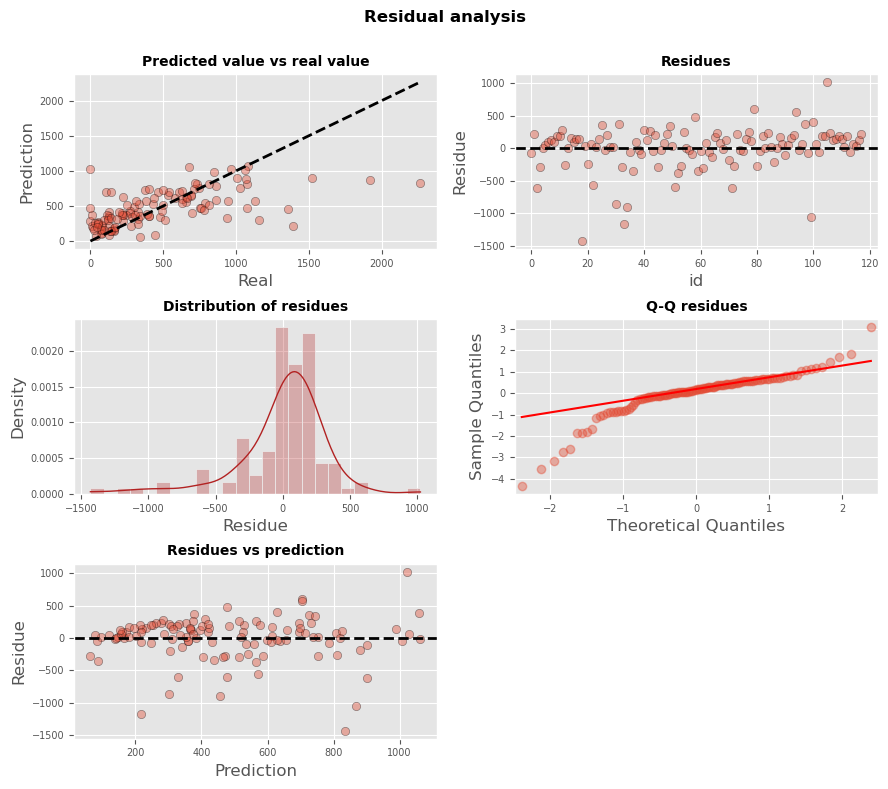

In [23]:
# Graphs
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediction_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                linestyle='--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residues', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residue')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residues_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribution of residues', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residue")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residues_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residues', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_train, residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residues vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residue')
axes[2, 0].tick_params(labelsize = 7)

# Eliminate empty axes
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Residual analysis', fontsize = 12, fontweight = "bold");

### test de normalidad 

In [24]:
# Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residues_train)
shapiro_test

ShapiroResult(statistic=0.8607012033462524, pvalue=3.77663145201268e-09)

In [25]:
# D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residues_train)
print(f"Statistic= {k2}, p-value = {p_value}")

Statistic= 47.02495444196522, p-value = 6.146967076922255e-11


### predicciones 

In [26]:
# # Predictions with 95% confidence intervals
# ==============================================================================
predictions = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predictions.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,785.145453,50.692961,684.732453,885.558452,114.457818,1455.833087
1,278.668063,40.668593,198.111407,359.224719,-389.335311,946.671437
2,330.149952,41.041519,248.854601,411.445303,-337.942906,998.242810
3,470.357859,39.638288,391.842039,548.873679,-197.402477,1138.118196


In [27]:
# Model error test
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predictions = model.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predictions,
        squared = False
       )
print("")
print(f"The test error (rmse) is: {rmse}")


The test error (rmse) is: 406.50346727658604


In [28]:
movies['box_office'].mean()

472.55049696621626

In [29]:
movies.describe()

,personal_rating,imdb,year,duration,budget,box_office,fan_rating
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,90.547297,7.242568,2011.040541,115.040541,102.098931,472.550497,84.027926
std,7.742747,0.934311,9.685446,24.375151,81.237286,412.783019,7.465067
min,60.000000,4.300000,1975.000000,72.000000,0.050000,0.408400,53.666667
25%,86.500000,6.600000,2006.000000,96.000000,28.750000,140.325000,79.654412
50%,90.000000,7.300000,2012.500000,109.000000,90.000000,352.016034,84.854396
75%,96.000000,8.000000,2019.000000,127.250000,154.000000,714.737760,89.413462
max,100.000000,9.000000,2023.000000,194.000000,393.216000,2264.743305,96.428571


In [30]:
model.params

Intercept   -642.881236
budget         2.861330
imdb         114.480741
dtype: float64

## Interpretación de los resultados


The multiple linear regression that we obtained,

$$box office = -642.881236 + 114.48imdb + 2.861330budget$$,

can explain 36.5% of the observed box office variance (*R-squared*: 0.365, *Adj. R-squared*: 0.352). The *F* test is significant (*$p$-value*: 2.23e-11). This numbers indicate that our data base is not ideal to be used for multiple linear regression. The statistical tests performed in this paper were made in order to prove that in each movie, some aspects such as the the imdb rating and budget for making it are related to its box office. However, since this model could not perform the aproppiate predictions, the previous statement cannot be confirmed.

The model error test is 406.503 (aproximately), so the model predictions get farther from the real value by 406.503 **on average**; which again confirms that this regression analysis is not reliable, due to some imperfections of the data base used. 



## Modificaciones del código sin el intercepto

In [31]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration', 'budget','personal_rating','imdb']]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ duration + budget + personal_rating + imdb +0', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             fan_rating   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              4008.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                   1.40e-121
Time:                        11:59:22   Log-Likelihood:                         -398.74
No. Observations:                 118   AIC:                                      805.5
Df Residuals:                     114   BIC:                                      816.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
duration            0.0638      0.030      2.160      0.033       0.005       0.122
budget             -0.0048      0.009     -0.560      0.577      -0.022       0.012
personal_rating     0.7438      0.055     13.483      0.000       0.635       0.853
imdb                1.3071      0.725      1.804      0.074      -0.129       2.743
==============================================================================
Omnibus:                        4.095   Durbin-Watson:                   2.328
Prob(Omnibus):                  0.129   Jarque-Bera (JB):                3.932
Skew:                          -0.255   Prob(JB):                        0.140
Kurtosis:                       3.734   Cond. No.                         202.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Al eliminar el intercepto nuestra r^2 aumentó a 0.993 Para poder realizar una buena regresión lineal múltiple, decidimos eliminar las variables en las que P>|t| fuera mayor a 0.05; esto con el fin de elevar nuestro valor de R^2 y aportar más exactitud al modelo. 
###### Al final solamente dejamos las variables de duración, imdb y budget, ya que fueron las que tenían el valor de P>|t| más pequeño.

In [32]:
# Model fitting using matrices
# ==============================================================================
# Add a column of 1s to the predictor matrix
X_train = sm.add_constant(X_train, prepend=True)

In [33]:
model = sm.OLS(endog=y_train, exog=X_train,)
model = model.fit()
#print(model.summary())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             fan_rating   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     7.707
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           1.58e-05
Time:                        12:00:23   Log-Likelihood:                -387.68
No. Observations:                 118   AIC:                             785.4
Df Residuals:                     113   BIC:                             799.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              41.0293      8.498      4.828      0.000      24.192      57.866
duration            0.0529      0.027      1.950      0.054      -0.001       0.107
budget             -0.0071      0.008     -0.902      0.369      -0.023       0.009
personal_rating     0.4094      0.086      4.778      0.000       0.240       0.579
imdb                0.0782      0.710      0.110      0.912      -1.328       1.485
==============================================================================
Omnibus:                       13.619   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.635
Skew:                          -0.823   Prob(JB):                     0.000664
Kurtosis:                       3.519   Cond. No.                     2.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### Eliminamos la variable de fan_rating primero. Sin embargo, nos dimos cuenta que nuestra R^2 seguía siendo muy baja, tomando en cuenta el intercepto, por lo que continuamos eliminando más variables y el intercepto.

In [34]:
# Train-test Splitting
# ==============================================================================
X = movies[['duration','personal_rating']]
y = movies['fan_rating']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Model fitting using a formula
# ==============================================================================
# Creating a DataFrame for the model using X_train and y_train
model_data = pd.concat([X_train, y_train], axis=1)

model = smf.ols(formula='fan_rating ~ duration + personal_rating+0', data=model_data)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             fan_rating   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              7894.
Date:                Wed, 29 Nov 2023   Prob (F-statistic):                   1.12e-124
Time:                        12:00:59   Log-Likelihood:                         -400.65
No. Observations:                 118   AIC:                                      805.3
Df Residuals:                     116   BIC:                                      810.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
duration            0.0803      0.026      3.051      0.003       0.028       0.132
personal_rating     0.8221      0.034     24.120      0.000       0.755       0.890
==============================================================================
Omnibus:                        3.925   Durbin-Watson:                   2.327
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                3.761
Skew:                          -0.241   Prob(JB):                        0.153
Kurtosis:                       3.730   Cond. No.                         9.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### En esta etapa ya eliminamos las variables con valor de P mayor a 0.05, ahora podemos continuar haciendo la regresión lineal múltiple.

### A continuación se presentan los gráficos del modelo de regresión:
Utilizaremos la variable fan rating para realizar el modelo

In [35]:
# Confidence intervals for the coefficients
# ==============================================================================
intervals_ci = model.conf_int(alpha=0.05)
intervals_ci.columns = ['2.5%', '97.5%']
intervals_ci

,2.5%,97.5%
duration,0.028179,0.132470
personal_rating,0.754614,0.889633


In [36]:
# Residual analysis
# ==============================================================================
prediction_train = model.predict(exog=X_train)
residues_train = prediction_train - y_train.values.flatten()

/Users/jessica/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


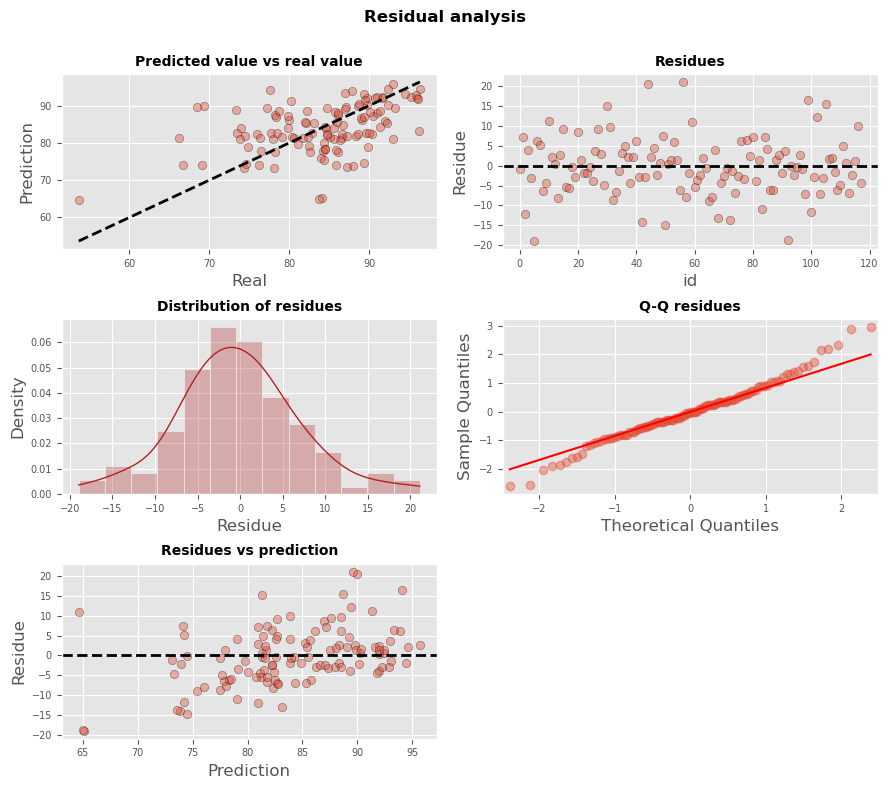

In [37]:
# Graphs
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

axes[0, 0].scatter(y_train, prediction_train, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                linestyle='--', color = 'black', lw=2)
axes[0, 0].set_title('Predicted value vs real value', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Prediction')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residues', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residue')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = residues_train,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribution of residues', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residue")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    residues_train,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residues', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

axes[2, 0].scatter(prediction_train, residues_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[2, 0].set_title('Residues vs prediction', fontsize = 10, fontweight = "bold")
axes[2, 0].set_xlabel('Prediction')
axes[2, 0].set_ylabel('Residue')
axes[2, 0].tick_params(labelsize = 7)

# Eliminate empty axes
fig.delaxes(axes[2,1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Residual analysis', fontsize = 12, fontweight = "bold");

### test de normalidad 


In [38]:
# Shapiro-Wilk test
# ==============================================================================
shapiro_test = stats.shapiro(residues_train)
shapiro_test

ShapiroResult(statistic=0.9847656488418579, pvalue=0.20484767854213715)

In [39]:
# D'Agostino's K-squared test
# ==============================================================================
k2, p_value = stats.normaltest(residues_train)
print(f"Statistic= {k2}, p-value = {p_value}")

Statistic= 3.9247401541014004, p-value = 0.1405249709174125


### predicciones 

In [40]:
# # Predictions with 95% confidence intervals
# ==============================================================================
predictions = model.get_prediction(exog = X_train).summary_frame(alpha=0.05)
predictions.head(4)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,77.511281,0.705776,76.113402,78.909160,63.027368,91.995194
1,81.782546,0.795586,80.206788,83.358304,67.280384,96.284707
2,80.979304,0.966849,79.064339,82.894270,66.436376,95.522232
3,83.870974,0.704959,82.474713,85.267235,69.387217,98.354731


In [41]:
# Model error test
# ==============================================================================
X_test = sm.add_constant(X_test, prepend=True)
predictions = model.predict(exog = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predictions,
        squared = False
       )
print("")
print(f"The test error (rmse) is: {rmse}")


The test error (rmse) is: 8.830589818344563


In [42]:
movies['fan_rating'].mean()

84.02792613358596

In [43]:
movies.describe()

,personal_rating,imdb,year,duration,budget,box_office,fan_rating
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,90.547297,7.242568,2011.040541,115.040541,102.098931,472.550497,84.027926
std,7.742747,0.934311,9.685446,24.375151,81.237286,412.783019,7.465067
min,60.000000,4.300000,1975.000000,72.000000,0.050000,0.408400,53.666667
25%,86.500000,6.600000,2006.000000,96.000000,28.750000,140.325000,79.654412
50%,90.000000,7.300000,2012.500000,109.000000,90.000000,352.016034,84.854396
75%,96.000000,8.000000,2019.000000,127.250000,154.000000,714.737760,89.413462
max,100.000000,9.000000,2023.000000,194.000000,393.216000,2264.743305,96.428571


In [44]:
model.params

duration           0.080324
personal_rating    0.822123
dtype: float64

## Interpretación de los resultados



The multiple linear regression that we obtained,

$$fan rating = 0.080324duration + 0.822123personalrating$$,

can explain 99.3% of the observed fan rating variance (*R-squared*: 0.993, *Adj. R-squared*: 0.993). The *F* test is significant (*$p$-value*: 0.1405249709174127). This means that the variance explained and calculated by this multiple linear regression model is greater than that of random chance.

Normality is not satisfied, so the estimated confidence intervals for the coefficients are not reliable.

The model error test is 8.830589818344563 (aproximately), so the model predictions get farther from the real value by 8.830589818344563 **on average**; which again confirms that this regression analysis is is very reliable, since our value for the error is less than a 10%; it is not perfect, but can work properly. 

